## City of Toronto Collisions Data


The Total Collisions Dataset is a CSV file containing detailed records of motor vehicle collisions within the City of Toronto. The dataset uses the WGS84 Coordinate Reference System, ensuring consistent geographic representation of collision locations. Key attributes include the geographic location of each collision, whether it resulted in a fatality or injury, and the timestamp of the event. For our analysis, we will focus on data from 2019 to 2023 to align with recent census data, providing insights into contemporary trends and patterns in collisions. Additionally, the dataset may include supplementary fields such as road conditions, weather visibility, and types of vehicles involved, offering a comprehensive view of the contributing factors to these incidents. By analyzing this dataset, we aim to identify high-risk areas and underlying causes of collisions to inform preventative strategies and improve road safety.

## Setup Notebook

In [1]:
# Import 3rd party libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pylab as plt
import geopandas as gpd
import matplotlib.pyplot as plt
import folium
from IPython.display import display
import geopandas as gpd
from shapely.geometry import Point

# Configure Notebook
%matplotlib inline
plt.style.use('fivethirtyeight')
sns.set_context("notebook")
import warnings
warnings.filterwarnings('ignore')

/Users/aaliyashaikh/Library/Python/3.8/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


## Import GeoJson Data

To begin analyzing traffic collision data, we first need to load the dataset. The data is stored in GeoJSON format, which contains geographical information that can be processed using a GeoDataFrame in the geopandas library. Below, we import the dataset and display the first few rows to get an overview of the data structure:

In [57]:
# Import dataset as a GeoDataFrame
collision_data = gpd.read_file('../../data_files/Traffic_Collisions_Open_Data_-6024052409346627848.geojson')

collision_data.head()


,OBJECTID,EVENT_UNIQUE_ID,OCC_DATE,OCC_MONTH,OCC_DOW,OCC_YEAR,OCC_HOUR,DIVISION,FATALITIES,INJURY_COLLISIONS,...,HOOD_158,NEIGHBOURHOOD_158,LONG_WGS84,LAT_WGS84,AUTOMOBILE,MOTORCYCLE,PASSENGER,BICYCLE,PEDESTRIAN,geometry
0,1,GO-20148000005,"Wed, 01 Jan 2014 05:00:00 GMT",January,Wednesday,2014,13,D23,0,NO,...,006,Kingsview Village-The Westway (6),-79.558639,43.694246,YES,NO,NO,NO,NO,POINT (-79.55864 43.69425)
1,2,GO-20148000085,"Wed, 01 Jan 2014 05:00:00 GMT",January,Wednesday,2014,19,D42,0,NO,...,128,Agincourt South-Malvern West (128),-79.281506,43.784746,YES,NO,NO,NO,NO,POINT (-79.28151 43.78475)
2,3,GO-20141260499,"Wed, 01 Jan 2014 05:00:00 GMT",January,Wednesday,2014,2,NSA,0,YES,...,NSA,NSA,0.000000,0.000000,YES,NO,NO,NO,NO,POINT (0.00000 0.00000)
3,4,GO-20141260663,"Wed, 01 Jan 2014 05:00:00 GMT",January,Wednesday,2014,3,NSA,0,NO,...,NSA,NSA,0.000000,0.000000,YES,NO,NO,NO,NO,POINT (0.00000 0.00000)
4,5,GO-20141261162,"Wed, 01 Jan 2014 05:00:00 GMT",January,Wednesday,2014,5,NSA,0,YES,...,NSA,NSA,0.000000,0.000000,YES,NO,NO,NO,NO,POINT (0.00000 0.00000)


We can see that there are a lot of collisions in the City of Toronto. Now let's analyze that data in the dataset. 

## Data Analysis

Let's exploring the collision data columns (features).

In [3]:
# Check the number of columns and rows
collision_data.shape

(704704, 22)

In [4]:
# Check the columns in DataFrame
collision_data.columns

Index(['OBJECTID', 'EVENT_UNIQUE_ID', 'OCC_DATE', 'OCC_MONTH', 'OCC_DOW',
       'OCC_YEAR', 'OCC_HOUR', 'DIVISION', 'FATALITIES', 'INJURY_COLLISIONS',
       'FTR_COLLISIONS', 'PD_COLLISIONS', 'HOOD_158', 'NEIGHBOURHOOD_158',
       'LONG_WGS84', 'LAT_WGS84', 'AUTOMOBILE', 'MOTORCYCLE', 'PASSENGER',
       'BICYCLE', 'PEDESTRIAN', 'geometry'],
      dtype='object')

Based on the Toronto Police Service's Traffic Collisions Open Data (ASR-T-TBL-001), here is a description of each column in the dataset:

- OBJECTID: A unique identifier for each collision record.
- EVENT_UNIQUE_ID: A unique code assigned to each specific event.
- OCC_DATE: The date and time of the collision occurrence.
- OCC_MONTH: The month in which the collision occurred.
- OCC_DOW: The day of the week on which the collision happened.
- OCC_YEAR: The year in which the collision occurred.
- OCC_HOUR: The hour of the day (24-hour format) when the collision took place.
- DIVISION: The division code where the incident was recorded.
- FATALITIES: The number of fatalities resulting from the collision.
- INJURY_COLLISIONS: Indicates whether the collision involved injuries (e.g., "YES" or "NO").
- FTR_COLLISIONS: Indicates whether the collision was a "Fail to Remain" incident.
- PD_COLLISIONS: Indicates whether the collision involved property damage.
- HOOD_158: Numeric code representing the neighborhood where the collision occurred.
- NEIGHBOURHOOD_158: The name of the neighborhood and its associated number.
- LONG_WGS84: Longitude of the collision location (in WGS84 coordinate system).
- LAT_WGS84: Latitude of the collision location (in WGS84 coordinate system).
- AUTOMOBILE: Indicates if an automobile was involved in the collision (e.g., "YES" or "NO").
- MOTORCYCLE: Indicates if a motorcycle was involved in the collision.
- PASSENGER: Indicates if a passenger vehicle was involved in the collision.
- BICYCLE: Indicates if a bicycle was involved in the collision.
- PEDESTRIAN: Indicates if a pedestrian was involved in the collision.
- geometry: A spatial coordinate (likely projected coordinate system) for mapping the location.


In [5]:
# Check data types per column
print(collision_data.dtypes)

OBJECTID                int64
EVENT_UNIQUE_ID        object
OCC_DATE               object
OCC_MONTH              object
OCC_DOW                object
OCC_YEAR               object
OCC_HOUR               object
DIVISION               object
FATALITIES              int64
INJURY_COLLISIONS      object
FTR_COLLISIONS         object
PD_COLLISIONS          object
HOOD_158               object
NEIGHBOURHOOD_158      object
LONG_WGS84            float64
LAT_WGS84             float64
AUTOMOBILE             object
MOTORCYCLE             object
PASSENGER              object
BICYCLE                object
PEDESTRIAN             object
geometry             geometry
dtype: object


In [6]:
# Check numerical statistics for each column
collision_data.describe()

,OBJECTID,FATALITIES,LONG_WGS84,LAT_WGS84
count,704704.000000,704704.000000,704704.000000,704704.000000
mean,352352.500000,0.000873,-66.342691,36.528215
std,203430.666387,0.030053,29.423231,16.200397
min,1.000000,0.000000,-79.639247,0.000000
25%,176176.750000,0.000000,-79.444829,43.644346
50%,352352.500000,0.000000,-79.370469,43.692500
75%,528528.250000,0.000000,-79.258521,43.751480
max,704704.000000,3.000000,0.000000,43.853164


When analyzing collision data, it is important to streamline the dataset by removing less relevant or redundant columns, allowing us to focus on the key variables for our analysis. Below, we drop several columns that do not contribute meaningfully to our objectives or are redundant because the information can be derived from other columns (e.g., OCC_MONTH and OCC_YEAR can be inferred from OCC_DATE). Additionally, we rename certain columns to make their purpose clearer and improve readability.



In [7]:
# Drop columns
collision_data = collision_data.drop(columns=[
    'OBJECTID',               # Unique identifier, not informative for analysis
    'EVENT_UNIQUE_ID',        # Another unique identifier, redundant
    'HOOD_158',               # Numeric code for neighborhoods, redundant with neighborhood name
    'INJURY_COLLISIONS',      # Specific collision categories, may not fit broader analysis
    'NEIGHBOURHOOD_158',      # Redundant if detailed spatial analysis isn't required
    'OCC_MONTH',              # Month derivable from OCC_DATE
    'OCC_YEAR',               # Year derivable from OCC_DATE
    'OCC_DOW',                # Day of week derivable from OCC_DATE
    'DIVISION',               # Redundant for neighborhood-focused analysis
    'PASSENGER',              # Overlaps with automobile classification
    'AUTOMOBILE',             # May be less relevant if focusing on broader vehicle data
    'FATALITIES',             # May not fit broad collision trends
    'FTR_COLLISIONS',         # Specific collision subcategories
    'PD_COLLISIONS',          # Specific collision subcategories
    'MOTORCYCLE',             # May not fit focus of general collision analysis
    'BICYCLE',                # May not fit focus of general collision analysis
    'PEDESTRIAN',             # May not fit focus of general collision analysis
], errors='ignore')

# Rename columns in the GeoDataFrame
collision_data.rename(columns={
    'OCC_DATE': 'DATE',            # Rename to better indicate the data's purpose
    'LONG_WGS84': 'LONGITUDE',     # Simplify and clarify the name
    'LAT_WGS84': 'LATITUDE',       # Simplify and clarify the name
    'OCC_HOUR': 'HOUR'             # Rename for consistency
}, inplace=True)

# Check if columns are removed and remaining columns have been renamed
collision_data.columns


Index(['DATE', 'HOUR', 'LONGITUDE', 'LATITUDE', 'geometry'], dtype='object')

## Data Cleaning

Data cleaning for the collision dataset ensures:

- Accuracy: Removes errors and inconsistencies.
- Efficiency: Streamlines the dataset for quicker and easier analysis.
- Reliability: Produces trustworthy insights and recommendations.
- Focus: Tailors the data for the specific analysis of collision patterns and trends.

Given the large size of the traffic collision dataset, it would be inefficient to work with the entire dataset when we're only interested in data from 2019 to 2023. To streamline our analysis, we will filter the dataset to focus solely on the relevant records from these years. This approach reduces the amount of data we're working with and helps optimize processing time. The following code extracts only the collisions that occurred between 2019 and 2023, dropping any other records:

In [8]:
# Convert the 'collision_date' column to datetime (replace 'collision_date' with the actual column name)
collision_data['DATE'] = pd.to_datetime(collision_data['DATE'])

# Filter data from 2019 to 2023 and drop all other entries
collision_data_filtered = collision_data[(collision_data['DATE'].dt.year >= 2019) & 
                                         (collision_data['DATE'].dt.year <= 2023)]

# Verify the results by displaying the first few rows
collision_data_filtered.head()


,DATE,HOUR,LONGITUDE,LATITUDE,geometry
354994,2019-01-01 05:00:00,1,-79.412663,43.781332,POINT (-79.41266 43.78133)
354995,2019-01-01 05:00:00,15,-79.298106,43.781057,POINT (-79.29811 43.78106)
354996,2019-01-01 05:00:00,4,-79.411207,43.665137,POINT (-79.41121 43.66514)
354997,2019-01-01 05:00:00,15,-79.619023,43.723466,POINT (-79.61902 43.72347)
354998,2019-01-01 05:00:00,8,-79.287580,43.727781,POINT (-79.28758 43.72778)


Before proceeding with any analysis, it's important to check the dataset for missing values. Missing or incomplete data can lead to inaccurate results or errors in processing. The following code will help us identify if there are any missing values in the traffic collision dataset and show the number of missing entries for each column:

In [9]:
# Check for missing values
print(collision_data_filtered.isnull().sum())

# Drop rows with any NaN values
collision_data_clean = collision_data_filtered.dropna()

# Verify the result by checking the number of missing values after dropping NaNs
print(collision_data_clean.isnull().sum())

DATE         0
HOUR         0
LONGITUDE    0
LATITUDE     0
geometry     0
dtype: int64
DATE         0
HOUR         0
LONGITUDE    0
LATITUDE     0
geometry     0
dtype: int64


Although there are no missing values there are several collisions that dont have coordinates.

In [10]:
# Drop rows where LONGITUDE or LATITUDE values are 0
collision_data_filtered = collision_data_filtered[(collision_data_filtered['LONGITUDE'] != 0) & 
                                                  (collision_data_filtered['LATITUDE'] != 0)]

# Verify the results by displaying the first few rows
collision_data_filtered.head()

,DATE,HOUR,LONGITUDE,LATITUDE,geometry
354994,2019-01-01 05:00:00,1,-79.412663,43.781332,POINT (-79.41266 43.78133)
354995,2019-01-01 05:00:00,15,-79.298106,43.781057,POINT (-79.29811 43.78106)
354996,2019-01-01 05:00:00,4,-79.411207,43.665137,POINT (-79.41121 43.66514)
354997,2019-01-01 05:00:00,15,-79.619023,43.723466,POINT (-79.61902 43.72347)
354998,2019-01-01 05:00:00,8,-79.287580,43.727781,POINT (-79.28758 43.72778)


** EXPLAIN WHY IM DROPPING THE COLLISIONS WITH POINT (0,0)

Since there is no missing data, we don't need to handle any specific missing values. 

To get an overview of the size of the dataset, it's useful to check the number of rows and columns it contains. The following code will display the shape of the traffic collision dataset, which will tell us how many entries (rows) and features (columns) are present:

In [11]:
collision_data_filtered.shape

(242916, 5)

Initially, I planned to remove duplicates as part of the data cleaning process. However, it's not advisable to drop duplicates in this dataset because multiple collisions can occur at the same time or at the same geographical coordinates (longitude and latitude). To ensure the integrity of the data, I chose not to remove any duplicates. I would typically  also remove outliers using the Interquartile Range method. However, outliers in traffic collision datasets often represent rare but significant events that can provide valuable insights. Removing these data points without careful consideration might undermine the depth and accuracy of the analysis, potentially overlooking critical patterns or impactful incidents.

That is all for data cleaning, let's see the new size of the dataset.

In [12]:
# View DataFrame
collision_data_filtered.tail()

,DATE,HOUR,LONGITUDE,LATITUDE,geometry
652998,2023-12-31 05:00:00,1,-79.328697,43.774133,POINT (-79.32870 43.77413)
652999,2023-12-31 05:00:00,13,-79.449539,43.678912,POINT (-79.44954 43.67891)
653000,2023-12-31 05:00:00,22,-79.381005,43.641755,POINT (-79.38100 43.64175)
653002,2023-12-31 05:00:00,18,-79.252902,43.810885,POINT (-79.25290 43.81089)
653003,2023-12-31 05:00:00,18,-79.309698,43.663366,POINT (-79.30970 43.66337)


## Visualization of Filtered Dataset

To visualize the traffic collision data, we can use the folium library, which allows for interactive mapping with geographical data. In this section, we'll create a base map centered on Toronto and overlay the traffic collision data from the GeoJSON file. The following code ensures that the data is correctly loaded and visualized on the map, with error handling to check for any issues with the file path:

In [13]:
# Define Toronto's latitude and longitude
#toronto_coords = [43.65107, -79.347015]

# Create a folium map centered on Toronto
#m = folium.Map(location=toronto_coords, zoom_start=12)

# Add each collision from collision_data_filtered to the map
#for _, row in collision_data_filtered.iterrows():
    #folium.CircleMarker(
       # location=[row['LATITUDE'], row['LONGITUDE']],
       # radius=1,  # Size of the marker
       # color='blue',  # Border color
      #  fill=True,
      #  fill_color='blue',  # Fill color
      #  fill_opacity=0.6  # Transparency
    #).add_to(m)

# Add a layer control panel
#folium.LayerControl().add_to(m)

# Display the map
#m

We can see that there are a lot of collisions in the City of Toronto. Now let's analyze that data in the dataset. 

## Exploratory Data Analysis of Collisions Data from 2019 to 2023

The exploratory data analysis (EDA) for the collisions dataset aims to uncover patterns, trends, and insights into the distribution and characteristics of collisions across Toronto. By examining factors such as temporal trends, spatial distributions, road conditions, light conditions, and driver behavior, we can better understand the key contributors to traffic incidents. This analysis provides a foundational understanding of the dataset, enabling us to identify high-risk areas, seasonal patterns, and other influential factors that impact collision frequency. Through this EDA, we aim to generate actionable insights that can inform road safety initiatives, policy decisions, and future predictive modeling efforts.

### Extracted Time Features from Collision Data

After converting the `DATE` column to a proper datetime format, we extracted several time-based attributes to analyze collision patterns more effectively. The following features were derived:

1. **Year**: The year in which the collision occurred.
2. **Month**: The month of the collision (1 = January, 12 = December).
3. **Day of the Week**: The name of the day (e.g., Monday, Tuesday).
4. **Hour**: The hour of the day when the collision occurred (0-23).

These features allow for temporal analysis of the data, such as identifying trends over years, seasonal patterns, or the most common days and hours for collisions. For example, examining collisions by the day of the week can help identify whether weekdays or weekends experience more accidents, while the hour attribute can reveal peak traffic or high-risk hours.


In [14]:
# Ensure the DATE column is in datetime format
collision_data_filtered['DATE'] = pd.to_datetime(collision_data_filtered['DATE'], errors='coerce')

# Extract year, month, and day of the week
collision_data_filtered['Year'] = collision_data_filtered['DATE'].dt.year
collision_data_filtered['Month'] = collision_data_filtered['DATE'].dt.month
collision_data_filtered['Day Of Week'] = collision_data_filtered['DATE'].dt.day_name()

# Drop the time portion in the DATE column
collision_data_filtered['DATE'] = collision_data_filtered['DATE'].dt.date

# Display the filtered DataFrame
collision_data_filtered.head()

,DATE,HOUR,LONGITUDE,LATITUDE,geometry,Year,Month,Day Of Week
354994,2019-01-01,1,-79.412663,43.781332,POINT (-79.41266 43.78133),2019,1,Tuesday
354995,2019-01-01,15,-79.298106,43.781057,POINT (-79.29811 43.78106),2019,1,Tuesday
354996,2019-01-01,4,-79.411207,43.665137,POINT (-79.41121 43.66514),2019,1,Tuesday
354997,2019-01-01,15,-79.619023,43.723466,POINT (-79.61902 43.72347),2019,1,Tuesday
354998,2019-01-01,8,-79.287580,43.727781,POINT (-79.28758 43.72778),2019,1,Tuesday



These extracted features will support predictive modeling, such as forecasting collisions by time or understanding time-based risk factors within each ward.

### Yearly Collision Trends Analysis

Understanding the yearly trends in collision data is essential for identifying patterns over time, such as increases or decreases in the number of collisions. This analysis can highlight the effectiveness of safety interventions or reveal emerging risks that require attention. By plotting the number of collisions for each year, we can assess long-term trends, which can inform city planning, policy-making, and resource allocation for traffic safety improvements. The following code calculates and visualizes the yearly collision trends from the dataset to provide these insights.


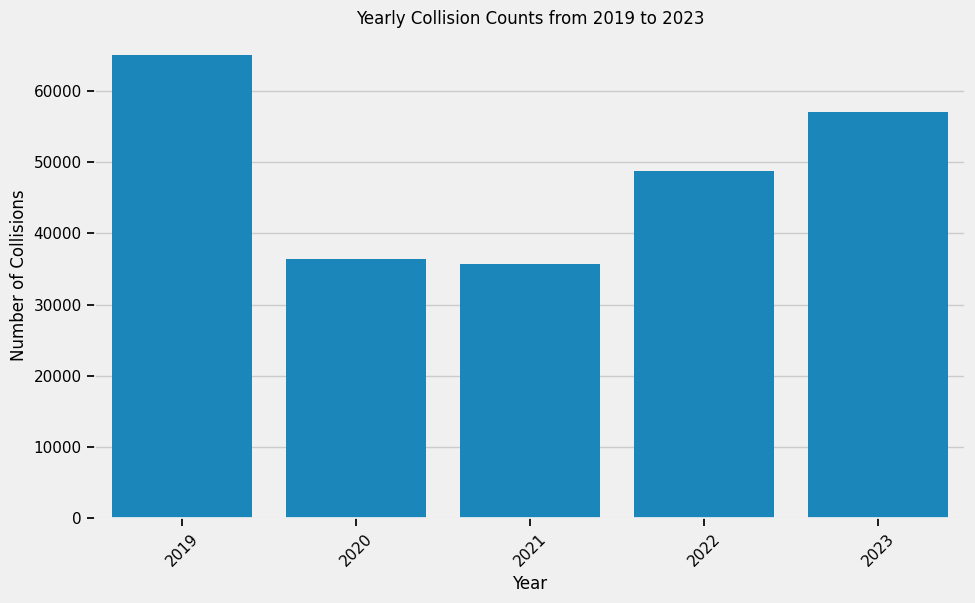

In [15]:
# Plot collisions per year from 2019 to 2023
plt.figure(figsize=(10, 6))
sns.countplot(x='Year', data=collision_data_filtered)
plt.title('Yearly Collision Counts from 2019 to 2023')
plt.xlabel('Year')
plt.ylabel('Number of Collisions')
plt.xticks(rotation=45)
plt.show()

The bar chart illustrates the number of traffic collisions in the City of Toronto from 2019 to 2023. The data reveals a notable trend: the year 2019 recorded the highest number of collisions, exceeding 80,000 incidents. However, a significant drop is observed in 2020, likely influenced by the COVID-19 pandemic, which led to reduced traffic volumes due to lockdowns and restrictions. Starting in 2021, the number of collisions began to increase steadily, reflecting a gradual return to normal traffic patterns as restrictions eased. By 2023, collision numbers approached pre-pandemic levels, signaling a potential normalization of traffic flow and activity. This trend emphasizes the direct correlation between traffic volume and collision occurrences, providing insight into the impact of external events like the pandemic on road safety.


### Monthly Collision Patterns 

Understanding the distribution of collisions across months provides valuable insights into seasonal trends and potential environmental or behavioral factors influencing road safety. Analyzing monthly collision patterns can help identify peak months for collisions, enabling policymakers and urban planners to implement targeted safety measures during high-risk periods. Below, we will explore the monthly collision trends using the dataset.

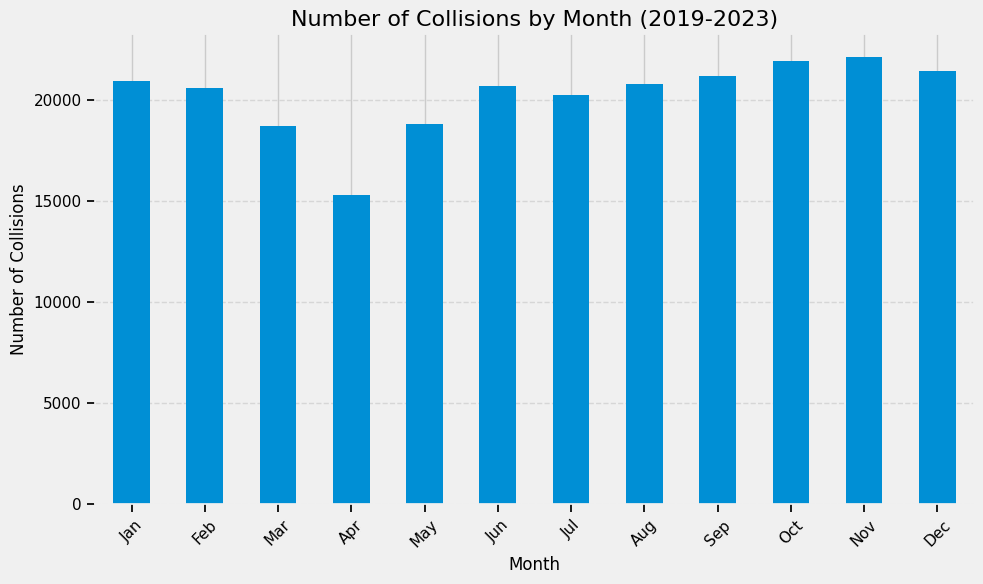

In [16]:
# Plot collisions per month
plt.figure(figsize=(10, 6))
collision_data_filtered["Month"].value_counts(sort=False).plot(kind="bar")
plt.title("Number of Collisions by Month (2019-2023)", fontsize=16)
plt.xlabel("Month", fontsize=12)
plt.ylabel("Number of Collisions", fontsize=12)
plt.xticks(ticks=range(0, 12), labels=["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"], rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()

# Show the plot
plt.show()

The bar chart displays the number of collisions occurring each month from 2019 to 2023. The data shows relatively consistent collision counts throughout the year, with most months experiencing between 20,000 to 25,000 collisions. January and February have slightly higher collision counts, possibly due to adverse weather conditions such as snow and ice, which are common during the winter months in Toronto. Conversely, April appears to have the lowest number of collisions, which could be attributed to milder weather and fewer adverse driving conditions. From June onwards, collision counts stabilize and remain consistently high through the fall months, peaking in October and November. This trend suggests that both weather conditions and seasonal traffic patterns may influence collision frequency.

#### Relationship between Month and Year
To explore the monthly collision trends across individual years from 2019 to 2023, we will use a series of bar plots, one for each year. This approach allows us to focus on the collision counts for each month within a given year, enabling a more granular examination of seasonal patterns and year-specific variations. By visualizing how collisions fluctuate month-by-month for each year, we can identify recurring trends, seasonal peaks, or anomalies specific to certain years. This targeted analysis is particularly useful for tailoring safety interventions and resource allocation to address year-specific collision patterns effectively.

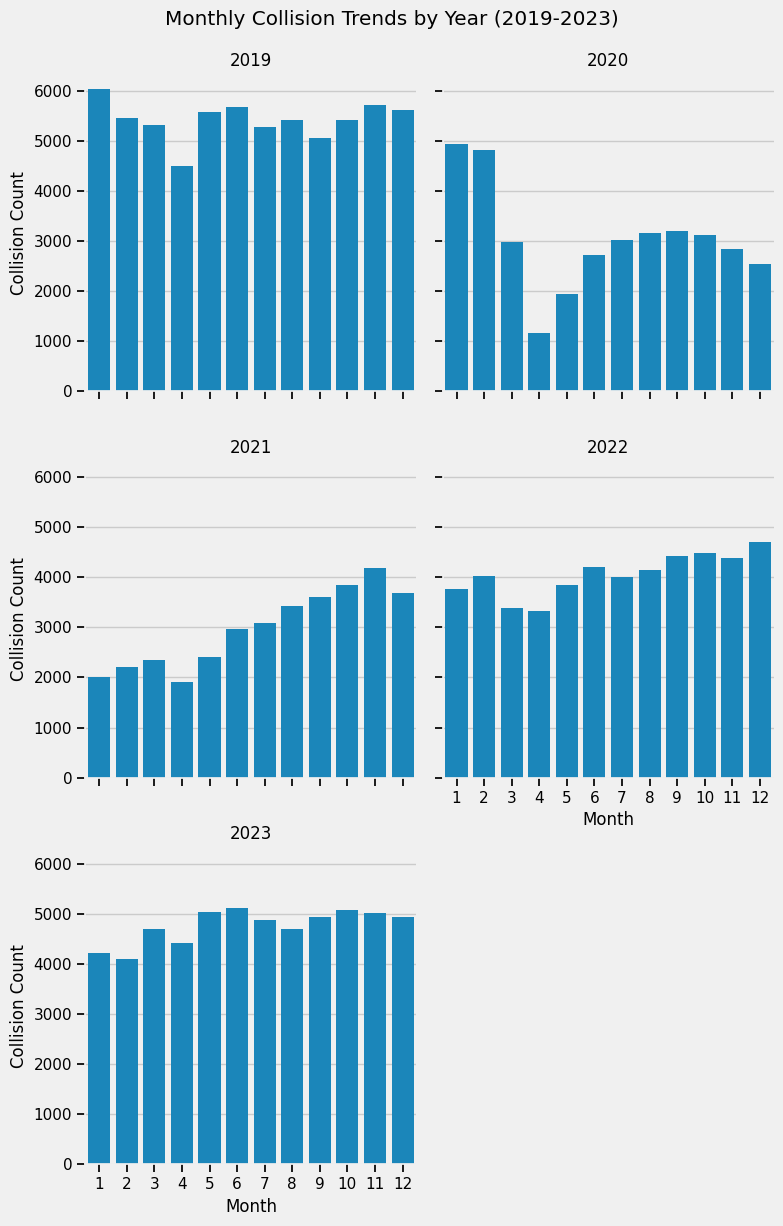

In [17]:
# Group the data by 'Year' and 'Month' to count the number of collisions per month per year
monthly_trends = collision_data_filtered.groupby(['Year', 'Month']).size().reset_index(name='Collision_Count')

# Create separate plots for each year showing monthly collision counts
g = sns.FacetGrid(monthly_trends, col="Year", col_wrap=2, height=4, sharey=True)
g.map(sns.barplot, "Month", "Collision_Count", order=range(1, 13))

# Set titles and labels
g.set_axis_labels("Month", "Collision Count")
g.set_titles("{col_name}")
g.fig.suptitle("Monthly Collision Trends by Year (2019-2023)", y=1.02)

plt.show()

The visualization breaks down the monthly collision trends for each year from 2019 to 2023.

- 2019: Collision counts remained relatively stable across all months, peaking slightly in January and December, possibly due to winter weather conditions. The year shows the highest collision activity, reflecting regular traffic patterns before the COVID-19 pandemic.
- 2020: A sharp decline in collision counts is evident, particularly from April to June, coinciding with the onset of the pandemic and associated lockdowns. Collisions gradually increased during the latter half of the year as restrictions eased but remained significantly below pre-pandemic levels.
- 2021: The data shows a steady rise in collisions throughout the year, starting at low levels in January and peaking around summer and fall. This trend aligns with the gradual reopening of activities and increasing traffic on the roads.
- 2022: Monthly collisions stabilized at higher levels compared to 2021, showing more consistent numbers across months, reflecting a near return to normal traffic patterns. However, the collision count was slightly lower than in 2019, suggesting a continued adjustment to post-pandemic dynamics.
- 2023: Collisions appear to have returned to a stable and high level, similar to 2019 but with slightly less fluctuation across months. The months of October and November show the highest counts, consistent with seasonal traffic trends.

This breakdown highlights the significant impact of the COVID-19 pandemic on traffic collisions, with reduced activity in 2020 and a gradual recovery toward pre-pandemic levels by 2023. Seasonal variations also remain evident across years.

### Day of the Week Collision Pattern

To further analyze collision patterns, we will examine how collisions are distributed across different days of the week. This analysis can help uncover trends related to weekly activities, such as increased traffic on weekdays due to work commutes or higher collision counts on weekends due to leisure travel. By visualizing these patterns, we can better understand how daily behaviors influence road safety and identify high-risk days for implementing targeted interventions.

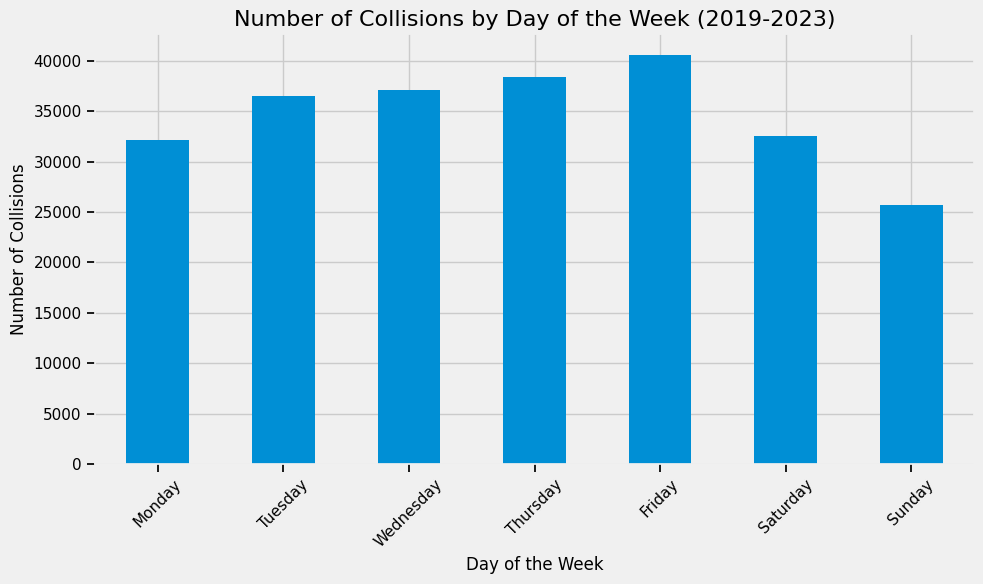

In [18]:
# Count the number of collisions for each day of the week
collisions_by_day = collision_data_filtered['Day Of Week'].value_counts()

# Reorder the days to follow the traditional weekly order
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
collisions_by_day = collisions_by_day.reindex(day_order)

# Plot the data
plt.figure(figsize=(10, 6))
collisions_by_day.plot(kind='bar')
plt.title('Number of Collisions by Day of the Week (2019-2023)', fontsize=16)
plt.xlabel('Day of the Week', fontsize=12)
plt.ylabel('Number of Collisions', fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()

# Display the graph
plt.show()

The bar chart illustrates the number of traffic collisions for each day of the week from 2019 to 2023.

- Weekday Trends: Collisions are consistently higher on weekdays, with Friday recording the highest number of incidents. This trend likely reflects the increased traffic volume on workdays, particularly during morning and evening commutes.
- Peak Days: Thursday and Tuesday also show notably high collision counts, slightly lower than Friday but higher than other weekdays. This might be attributed to regular workweek patterns where traffic is concentrated during peak hours.
- Weekend Trends: The collision counts drop significantly on weekends, with Sunday recording the lowest number of collisions. 
This decline could be due to reduced traffic volumes and fewer commuters on these days.

This pattern highlights the influence of weekday traffic patterns on collision occurrences, emphasizing the need for targeted road safety measures during high-traffic weekdays, particularly on Fridays.

###  Time of the Day Collision Patterns

This section of the analysis focuses on understanding the hourly patterns of traffic collisions. By examining how collisions are distributed across different hours of the day, we can identify peak times when accidents are most likely to occur. This insight is critical for implementing targeted traffic safety measures, optimizing resource allocation for emergency responders, and improving road safety during high-risk periods. The following code aggregates collision data by hour and visualizes these patterns to uncover meaningful trends.

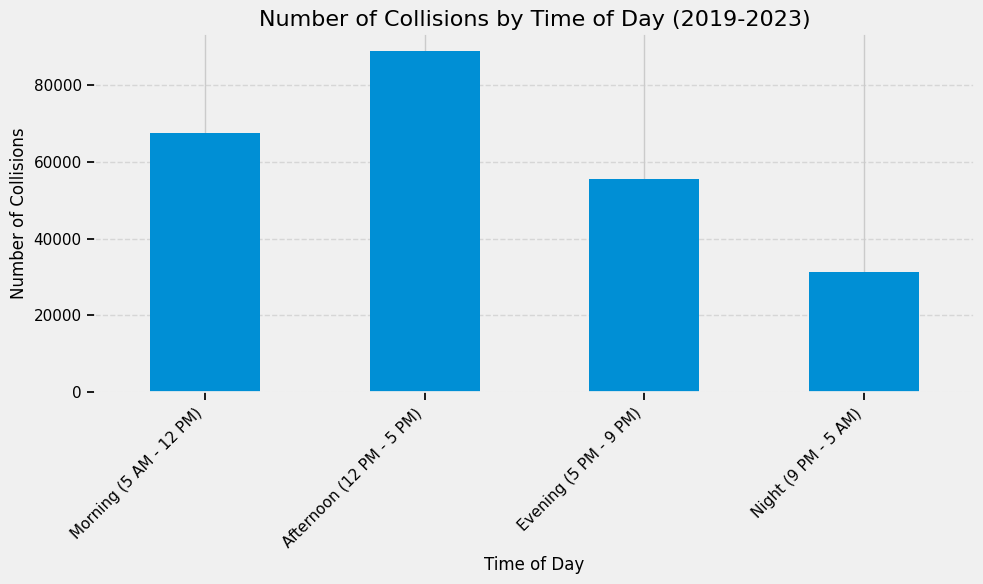

In [19]:
# Ensure the 'HOUR' column is converted to integers
collision_data_filtered['HOUR'] = collision_data_filtered['HOUR'].astype(int)

# Define time categories based on the hour of the day
def categorize_time(hour):
    if 5 <= hour < 12:
        return 'Morning (5 AM - 12 PM)'
    elif 12 <= hour < 17:
        return 'Afternoon (12 PM - 5 PM)'
    elif 17 <= hour < 21:
        return 'Evening (5 PM - 9 PM)'
    else:
        return 'Night (9 PM - 5 AM)'

# Apply the time categorization to the 'HOUR' column
collision_data_filtered['TIME_OF_DAY'] = collision_data_filtered['HOUR'].apply(categorize_time)

# Count collisions for each time category
collisions_by_time_of_day = collision_data_filtered['TIME_OF_DAY'].value_counts()

# Reorder categories for logical time progression
time_order = ['Morning (5 AM - 12 PM)', 'Afternoon (12 PM - 5 PM)', 'Evening (5 PM - 9 PM)', 'Night (9 PM - 5 AM)']
collisions_by_time_of_day = collisions_by_time_of_day.reindex(time_order)

# Plot the data
plt.figure(figsize=(10, 6))
collisions_by_time_of_day.plot(kind='bar')
plt.title('Number of Collisions by Time of Day (2019-2023)', fontsize=16)
plt.xlabel('Time of Day', fontsize=12)
plt.ylabel('Number of Collisions', fontsize=12)
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()

# Display the graph
plt.show()


## Import Ward Data

To predict the number of collisions in Toronto, the collision data must be spatially joined with the ward boundaries to determine which ward each collision occurred in. This process involves using the geographic coordinates (latitude and longitude) from the collision data and mapping them to the corresponding ward polygons in the ward dataset. After assigning collisions to their respective wards, we can aggregate the number of collisions per ward to identify trends and high-risk areas. This data can then be enriched with additional ward-specific features, such as population, road density, and traffic volume, to build a predictive model. By training a machine learning model with these features, we can forecast collision counts and provide actionable insights for city planning and traffic safety improvements.

In [20]:
# Load the shapefile
ward_shapefile_path = "WARD_WGS84.shx" 
ward_data = gpd.read_file(ward_shapefile_path.replace(".shx", ".shp"))  # Replace with .shp extension

# Create a base map
map_wards = folium.Map(location=[43.7, -79.4], zoom_start=11)  # Adjust to center on Toronto

# Add the ward shapefile to the map
ward_data_json = ward_data.to_json()  # Convert GeoDataFrame to GeoJSON
folium.GeoJson(ward_data_json, name="Wards").add_to(map_wards)

# Display the map
map_wards

## Ward Data Analysis 

In [21]:
# View geoDataFrame
ward_data.head()

,AREA_ID,AREA_TYPE,AREA_S_CD,AREA_L_CD,AREA_NAME,X,Y,LONGITUDE,LATITUDE,geometry
0,2551040,WD18,16,16,Don Valley East,318237.290,4844000.0,-79.33298,43.739716,"POLYGON ((-79.31335 43.71699, -79.31950 43.715..."
1,2551044,WD18,03,03,Etobicoke-Lakeshore,303099.474,4831000.0,-79.52087,43.621646,"POLYGON ((-79.49777 43.65198, -79.49725 43.651..."
2,2551048,WD18,15,15,Don Valley West,314825.876,4843000.0,-79.37536,43.728396,"POLYGON ((-79.35232 43.71573, -79.35209 43.715..."
3,2551052,WD18,23,23,Scarborough North,324522.149,4852000.0,-79.25467,43.809672,"POLYGON ((-79.22591 43.83960, -79.22556 43.839..."
4,2551056,WD18,11,11,University-Rosedale,313306.543,4837000.0,-79.39432,43.671139,"POLYGON ((-79.39004 43.69050, -79.39004 43.690..."


In [22]:
# Check the number of columns and rows
ward_data.shape

(25, 10)

In [23]:
# Check the columns in DataFrame
ward_data.columns

Index(['AREA_ID', 'AREA_TYPE', 'AREA_S_CD', 'AREA_L_CD', 'AREA_NAME', 'X', 'Y',
       'LONGITUDE', 'LATITUDE', 'geometry'],
      dtype='object')

The columns describe the following:
- 'AREA_ID': A unique identifier for each ward in the dataset.
- 'AREA_TYPE': Indicates the type of area (all is WD18 for wards in the 2018 model of Toronto).
- 'AREA_S_CD': A short code representing the ward, likely numeric.
- 'AREA_L_CD': A longer code that may provide additional context or differentiation for the ward.
- 'AREA_NAME': The official name of the ward.
- X,y : coordiantes in a projected coordinate system.
- Longitude, Latitude: Geographic lat and long of the ward's approximate center.
  
Let's explore the differences between 'AREA_S_CD' and 'AREA_L_CD'.

In [24]:
ward_data['AREA_S_CD'].unique()

array(['16', '03', '15', '23', '11', '10', '09', '05', '17', '08', '02',
       '01', '04', '12', '22', '21', '24', '25', '20', '19', '18', '06',
       '07', '14', '13'], dtype=object)

In [25]:
ward_data['AREA_L_CD'].unique()

array(['16', '03', '15', '23', '11', '10', '09', '05', '17', '08', '02',
       '01', '04', '12', '22', '21', '24', '25', '20', '19', '18', '06',
       '07', '14', '13'], dtype=object)

There are no differences between the two, therefore drop 'AREA_L_CD'. 

These other features will also be dropped:
- Drop 'AREA_ID' and let 'AREA_S_CD' act as the only identifier of the wards.
- Drop 'AREA_TYPE' as all wards are of type WD18, therefore, no new information or classification is provided. 

In [26]:
# Check data types per column
print(ward_data.dtypes)

AREA_ID         int64
AREA_TYPE      object
AREA_S_CD      object
AREA_L_CD      object
AREA_NAME      object
X             float64
Y             float64
LONGITUDE     float64
LATITUDE      float64
geometry     geometry
dtype: object


Can see that the 'AREA_L_CD' and 'AREA_NAME' are object files, therefore there is no need to convert these into string files.

## Ward Data Cleaning

In [27]:
# Drop unnecessary columns 
ward_data = ward_data.drop(columns = ['AREA_ID', 'AREA_S_CD', 'AREA_TYPE', 'X', 'Y', 'LONGITUDE', 'LATITUDE'], errors='ignore')

# Check the columnsare dropped in geoDataFrame
ward_data.columns

Index(['AREA_L_CD', 'AREA_NAME', 'geometry'], dtype='object')

In [28]:
# Check for missing values
print(ward_data.isnull().sum())
# Check for duplicates
ward_data.duplicated().sum()

AREA_L_CD    0
AREA_NAME    0
geometry     0
dtype: int64


0

In [29]:
# View geoDataFrame
ward_data.head()

,AREA_L_CD,AREA_NAME,geometry
0,16,Don Valley East,"POLYGON ((-79.31335 43.71699, -79.31950 43.715..."
1,03,Etobicoke-Lakeshore,"POLYGON ((-79.49777 43.65198, -79.49725 43.651..."
2,15,Don Valley West,"POLYGON ((-79.35232 43.71573, -79.35209 43.715..."
3,23,Scarborough North,"POLYGON ((-79.22591 43.83960, -79.22556 43.839..."
4,11,University-Rosedale,"POLYGON ((-79.39004 43.69050, -79.39004 43.690..."


The results indicate that there are no missing values or duplicate rows across key attributes like AREA_L_CD, AREA_NAME, X, Y, LONGITUDE, LATITUDE, and geometry. This suggests that the dataset is clean and ready for subsequent analysis, ensuring the integrity of the data for spatial operations and further processing.

## Overlay Collision Data onto Ward Data 


Overlaying the collision data onto the ward data is essential for spatial analysis and understanding where collisions are occurring within the city. By mapping each collision to a specific ward, we can identify patterns and trends in collision occurrences relative to geographic boundaries. This allows for aggregating the number of collisions per ward, which is critical for targeted analysis, policy-making, and resource allocation. For example, high-collision wards can be prioritized for road safety improvements or public awareness campaigns. Additionally, integrating collision data with ward-specific attributes such as population, traffic volume, or road density enables more accurate predictive modeling and helps address traffic safety issues more effectively.


Converting collision data into a GeoDataFrame is essential for spatial analysis, as it allows for operations like spatial joins, overlays, and mapping. By creating a geometry column from LATITUDE and LONGITUDE, each collision is represented as a precise point in space. Assigning a Coordinate Reference System (CRS), such as EPSG:4326 (WGS84), ensures the data aligns accurately with other spatial datasets, like ward boundaries. This conversion enables mapping collisions to specific wards, visualizing spatial patterns, and ensuring compatibility with geospatial tools, making it a critical step for reliable and accurate analysis.

In [30]:
# Convert collision data to GeoDataFrame
collision_data_filtered["geometry"] = collision_data_filtered.apply(lambda row: Point(row["LONGITUDE"], row["LATITUDE"]), axis=1)
collision_data_filtered = gpd.GeoDataFrame(collision_data_filtered, geometry="geometry", crs="EPSG:4326")

In [31]:
# Ensure CRS matches
#if collision_data_filtered.crs != ward_data.crs:
    #collision_data_filtered = collision_data_filtered.to_crs(ward_data.crs)

# Visualize on a map
#map_wards = folium.Map(location=[43.7, -79.4], zoom_start=11)
#ward_data_json = ward_data.to_json()
#folium.GeoJson(ward_data_json, name="Wards").add_to(map_wards)

# Add collision points
#for _, row in collision_data_filtered.iterrows():
   #folium.CircleMarker(
       #location=[row.geometry.y, row.geometry.x],
      # radius=1,
       #color="red",
       #fill=True,
       #fill_color="red",
       #fill_opacity=0.6
    #).add_to(map_wards)

#map_wards


To analyze the spatial distribution of traffic collisions, it is essential to determine which ward each collision occurred in. By performing a spatial join, we can combine the filtered collision dataset with the ward boundary data, allowing us to assign each collision to its corresponding ward. This spatial join uses the "within" operation to ensure collisions are matched to the wards they fall within geographically. After completing the spatial join, we drop unnecessary geometry columns to create a clean tabular format for easier analysis. The resulting table displays the collisions along with their associated ward information, as shown in the following code:

In [32]:
# Perform the spatial join to find which ward each collision occurred in
collision_with_wards = gpd.sjoin(collision_data_filtered, ward_data, how="left", op="within")

# Drop unnecessary geometry columns for tabular display
collision_table = collision_with_wards.drop(columns=["geometry", "index_right"])

# Rename columns in the GeoDataFrame
collision_table.rename(columns={
    'AREA_L_CD': 'Ward_Number',           
    'AREA_NAME': 'Ward_Name'
}, inplace=True)

# Display the table in the notebook
collision_table.head()  # Display first few rows of the table

,DATE,HOUR,LONGITUDE,LATITUDE,Year,Month,Day Of Week,TIME_OF_DAY,Ward_Number,Ward_Name
354994,2019-01-01,1,-79.412663,43.781332,2019,1,Tuesday,Night (9 PM - 5 AM),18,Willowdale
354995,2019-01-01,15,-79.298106,43.781057,2019,1,Tuesday,Afternoon (12 PM - 5 PM),22,Scarborough-Agincourt
354996,2019-01-01,4,-79.411207,43.665137,2019,1,Tuesday,Night (9 PM - 5 AM),11,University-Rosedale
354997,2019-01-01,15,-79.619023,43.723466,2019,1,Tuesday,Afternoon (12 PM - 5 PM),01,Etobicoke North
354998,2019-01-01,8,-79.287580,43.727781,2019,1,Tuesday,Morning (5 AM - 12 PM),20,Scarborough Southwest


To ensure that the results of our analysis are preserved and can be used for further processing or sharing, we can save the generated table into a GeoJson file. This approach creates a portable, non-geospatial version of the data that can be easily imported into other software tools for visualization or analysis. The following code saves the cleaned collision data with ward information into a GeoJson file:

In [33]:

# Convert 'DATE' field to string to avoid compatibility issues
if 'DATE' in collision_table.columns:
    collision_table['DATE'] = collision_table['DATE'].astype(str)

# Ensure 'geometry' column exists for GeoDataFrame compatibility
if 'geometry' not in collision_table.columns:
    collision_table['geometry'] = collision_table.apply(
        lambda row: Point(row['LONGITUDE'], row['LATITUDE']), axis=1
    )

# Convert to GeoDataFrame
collision_table_geo = gpd.GeoDataFrame(collision_table, geometry=collision_table['geometry'], crs="EPSG:4326")

# Save the GeoDataFrame to a GeoJSON file
output_geojson_path = "collision_data_with_wards.geojson"
collision_table_geo.to_file(output_geojson_path, driver="GeoJSON")


## Exploratory Data Analysis with Collision and Ward Data (2019 to 2023)

The exploratory data analysis (EDA) linking collision data to ward data focuses on understanding how traffic incidents are distributed across different geographic regions. By spatially associating each collision with its corresponding ward, we aim to identify high-risk areas, observe regional patterns, and analyze variations in collision frequency. This analysis allows us to explore how factors such as road conditions, traffic density, and infrastructure might vary across wards, influencing collision rates. By integrating collision and ward data, we can generate valuable insights to prioritize safety improvements, allocate resources effectively, and support data-driven decision-making at a regional level.

### Collisions Across Wards from 2019 to 2023

To better understand the distribution of traffic collisions across different wards, we can group the data by ward number and ward name, calculating both the total number and percentage of collisions for each ward from 2019 to 2023. This analysis helps identify which wards experience the highest or lowest collision rates. The wards are sorted in ascending order by ward number for clarity, and the percentage of collisions is calculated relative to the total collisions during the time period. The resulting summary table provides a concise overview of collision statistics for each ward, as shown in the following code:

In [34]:
# Rename columns in the GeoDataFrame
collision_table.rename(columns={
    'AREA_L_CD': 'Ward_Number',           
    'AREA_NAME': 'Ward_Name'
}, inplace=True)

# Group collisions by ward number and name, maintaining chronological order
ward_collision_counts = collision_table.groupby(["Ward_Number", "Ward_Name"]).size().reset_index(name="Number of Collisions")

# Sort wards in ascending order by ward number
ward_collision_counts = ward_collision_counts.sort_values(by="Ward_Number")

# Calculate the percentage of collisions for each ward
total_collisions = ward_collision_counts["Number of Collisions"].sum()
ward_collision_counts["Percentage of Collisions"] = (ward_collision_counts["Number of Collisions"] / total_collisions) * 100

# Display the summary DataFrame
ward_collision_counts.head(25)

,Ward_Number,Ward_Name,Number of Collisions,Percentage of Collisions
0,01,Etobicoke North,11325,4.677104
1,02,Etobicoke Centre,6782,2.800894
2,03,Etobicoke-Lakeshore,12061,4.981064
3,04,Parkdale-High Park,9147,3.777613
4,05,York South-Weston,10430,4.307479
5,06,York Centre,11164,4.610613
6,07,Humber River-Black Creek,9060,3.741683
7,08,Eglinton-Lawrence,9847,4.066706
8,09,Davenport,8384,3.462503
9,10,Spadina-Fort York,17606,7.271090


To ensure that the results of our analysis are preserved and can be used for further processing or sharing, we can save the generated table into a GeoJson file

In [35]:
# Convert the DataFrame to a GeoDataFrame
ward_collision_counts_gdf = gpd.GeoDataFrame(
    ward_collision_counts,
    geometry=collision_with_wards.geometry,  # Use the geometry from collision_with_wards
    crs="EPSG:4326"  # Define the coordinate reference system
)

# Save the GeoDataFrame as a GeoJSON file
output_geojson = "collisions_across_wards.geojson"
ward_collision_counts_gdf.to_file(output_geojson, driver="GeoJSON")

To gain a deeper understanding of how traffic collisions are distributed across all wards over time, we can visualize the number of collisions in each ward for every year from 2019 to 2023. This analysis highlights trends and patterns, such as whether certain wards consistently experience higher collision rates or if specific years saw significant changes in collision counts for particular wards. By breaking down the data by year, we can identify temporal variations and focus on wards that may require targeted traffic safety interventions. The following graph provides a comprehensive view of collision trends across all wards over the five-year period.

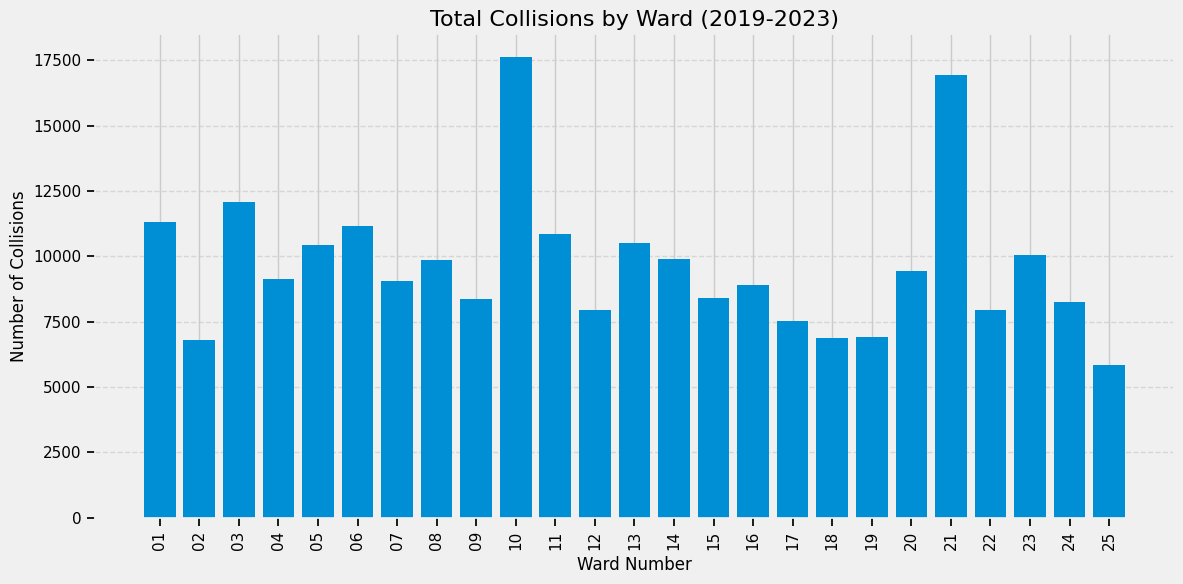

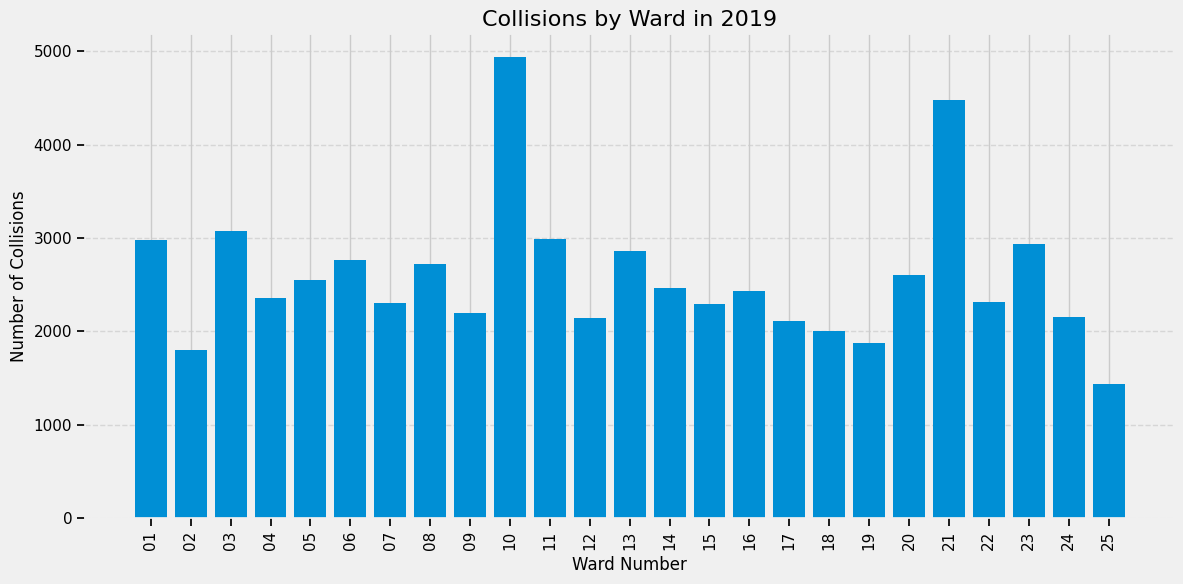

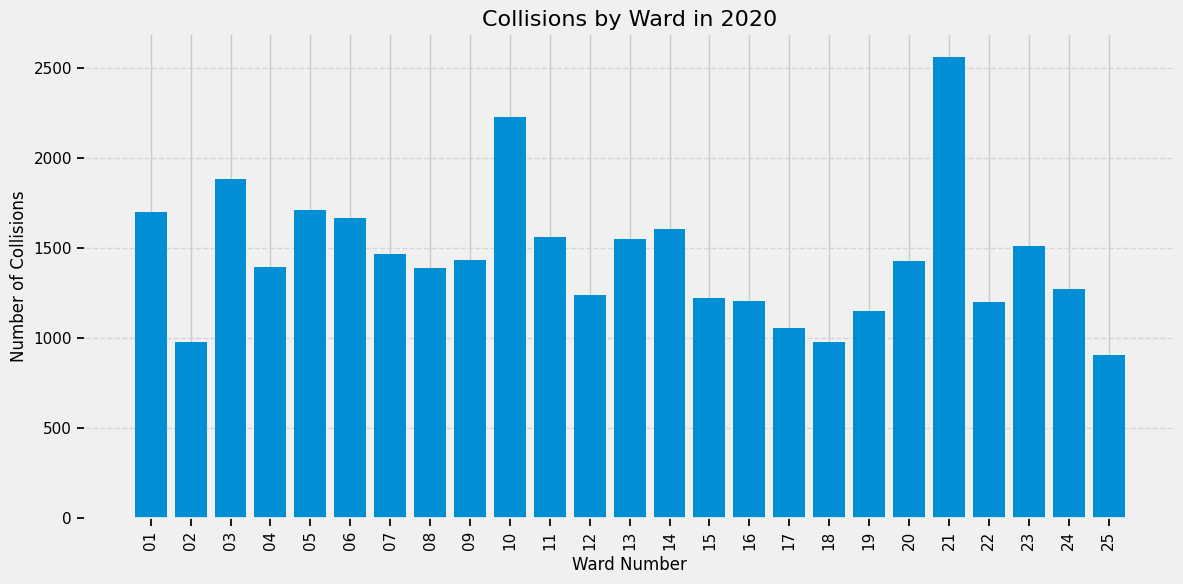

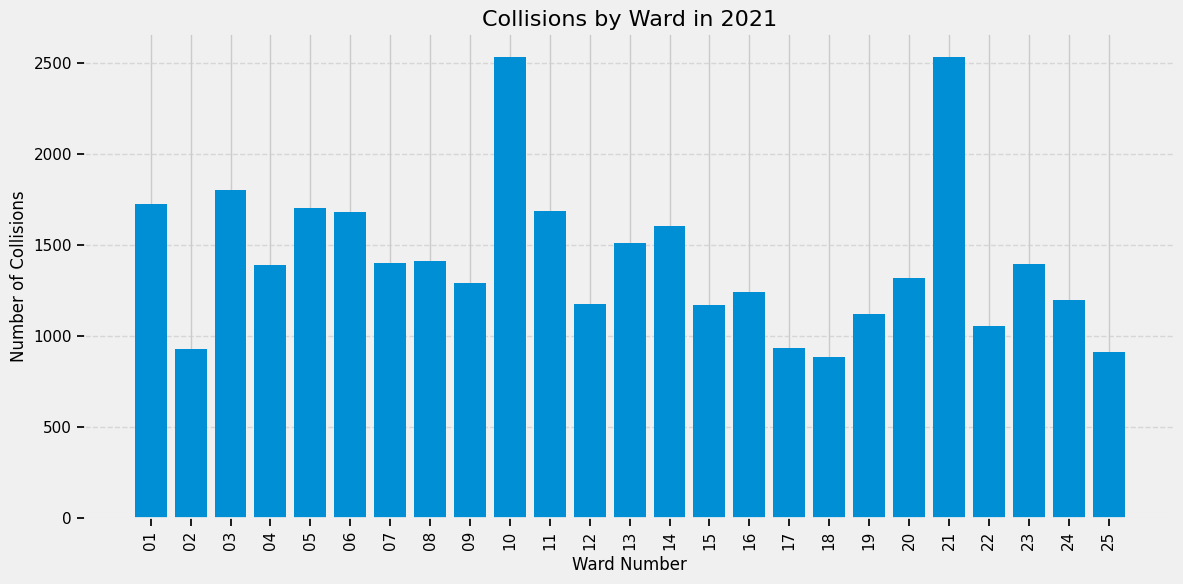

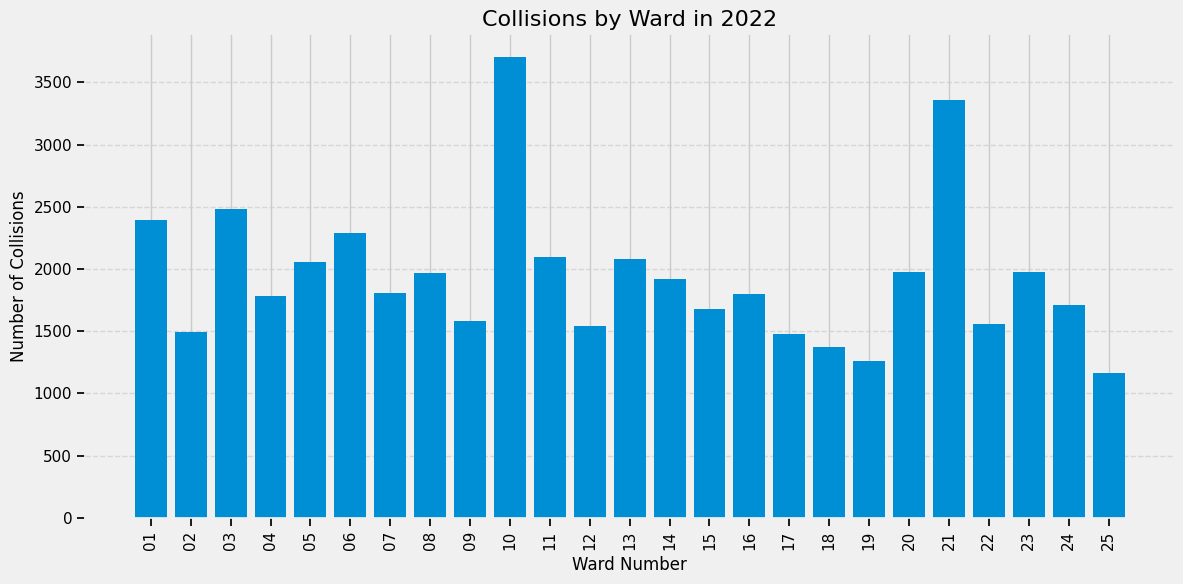

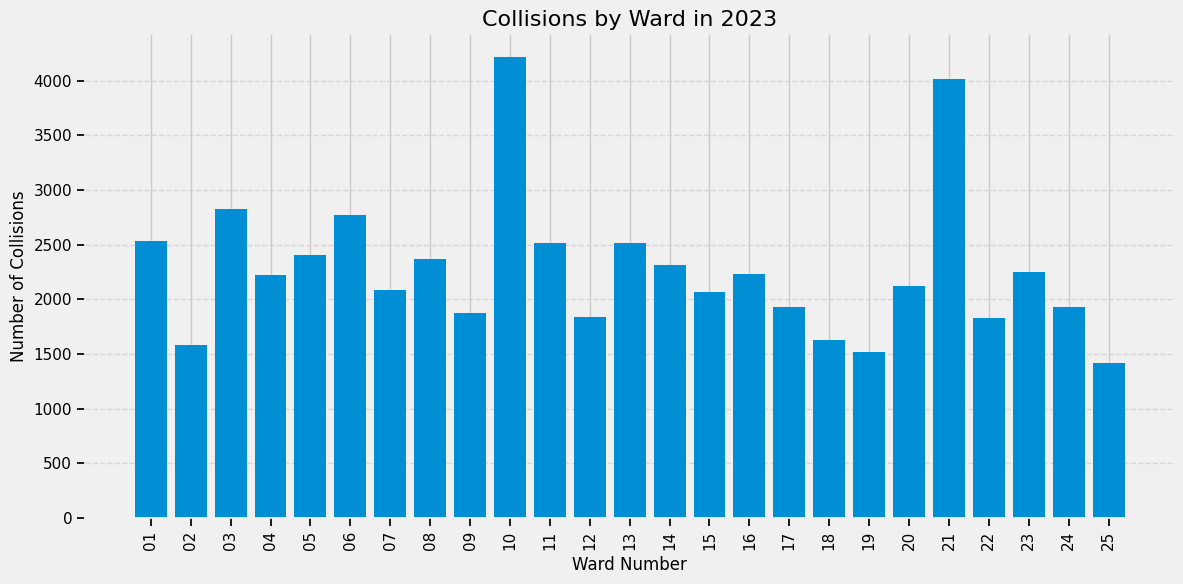

In [36]:
# Ensure the Year column exists and is numeric
collision_table['Year'] = pd.to_datetime(collision_table['DATE']).dt.year

# General graph: Total collisions by ward across all years
general_summary = collision_table.groupby(["Ward_Number", "Ward_Name"]).size().reset_index(name="Total Collisions")
general_summary = general_summary.sort_values(by="Ward_Number")

plt.figure(figsize=(12, 6))
plt.bar(general_summary["Ward_Number"], general_summary["Total Collisions"])
plt.title("Total Collisions by Ward (2019-2023)", fontsize=16)
plt.xlabel("Ward Number", fontsize=12)
plt.ylabel("Number of Collisions", fontsize=12)
plt.xticks(rotation=90)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# Create a graph for each year
for year in range(2019, 2024):
    yearly_data = collision_table[collision_table['Year'] == year]
    yearly_summary = yearly_data.groupby(["Ward_Number", "Ward_Name"]).size().reset_index(name="Collisions")
    yearly_summary = yearly_summary.sort_values(by="Ward_Number")
    
    plt.figure(figsize=(12, 6))
    plt.bar(yearly_summary["Ward_Number"], yearly_summary["Collisions"])
    plt.title(f"Collisions by Ward in {year}", fontsize=16)
    plt.xlabel("Ward Number", fontsize=12)
    plt.ylabel("Number of Collisions", fontsize=12)
    plt.xticks(rotation=90)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()


The first bar chart illustrates the total number of traffic collisions by ward in Toronto from 2019 to 2023. It reveals notable differences in collision frequency across the wards. Ward 10 and Ward 21 stand out as having the highest number of collisions, exceeding 17,000, indicating potential hotspots for traffic incidents. Conversely, some wards, such as Ward 2 and Ward 25, have significantly fewer collisions, with counts well below 10,000. This distribution suggests that traffic density, road infrastructure, and possibly ward-specific characteristics like population or commuting patterns play a significant role in influencing collision rates. These insights can be used to prioritize traffic safety measures and allocate resources more effectively in high-collision wards.

The second bar chart illustrates the number of traffic collisions by ward in Toronto for the year 2019. It reveals that Ward 10 and Ward 21 experienced the highest number of collisions, with counts exceeding 4,500. These wards stand out as potential areas of concern requiring focused traffic safety interventions. In contrast, Ward 2 and Ward 25 recorded significantly fewer collisions, with totals closer to 1,500, indicating relatively safer conditions or less traffic density in these areas. Most other wards demonstrate moderate collision frequencies, ranging between 2,000 and 3,500. This distribution highlights the variation in traffic collision patterns across the city, potentially influenced by factors such as population density, road infrastructure, and commuter behavior. These insights can guide city planners in prioritizing safety improvements for high-collision wards.

The third bar chart illustrates the number of traffic collisions by ward in Toronto for the year 2020. Compared to 2019, a noticeable reduction in collision counts is observed, likely due to the impacts of the COVID-19 pandemic and associated lockdowns, which significantly reduced traffic volumes across the city. Despite the overall decrease, Ward 21 remains a hotspot with the highest number of collisions, exceeding 2,500, followed by Ward 10. In contrast, Ward 2 and Ward 25 again recorded the lowest number of collisions, each with totals below 1,000. Other wards experienced moderate collision frequencies, reflecting consistent patterns of activity relative to traffic distribution. These insights highlight the persistent traffic risks in high-collision wards, even during periods of reduced road activity.

The fourth bar chart illustrates the number of traffic collisions by ward in Toronto for the year 2021. Compared to previous years, there is a noticeable increase in collision counts as traffic volumes began returning to pre-pandemic levels. Ward 10 and Ward 21 remain the most collision-prone areas, with counts exceeding 2,500, reflecting consistent traffic activity or infrastructure challenges in these wards. Conversely, Ward 2 and Ward 25 continue to experience the fewest collisions, with totals below 1,000, indicating relatively lower traffic density or safer road conditions. Most other wards show moderate collision counts, ranging between 1,000 and 2,000. This distribution highlights ongoing patterns in high-risk areas, emphasizing the need for targeted road safety initiatives in the wards with persistently high collision rates.

The fifth bar chart shows the number of traffic collisions by ward in Toronto for the year 2022. Collision counts have continued to rise compared to earlier years, reflecting the normalization of traffic patterns post-pandemic. Wards 10 and 21 remain the most collision-prone areas, with Ward 10 experiencing over 3,500 collisions, indicating persistent traffic activity or infrastructure challenges in these regions. Conversely, Wards 2 and 25 again record the fewest collisions, with totals below 1,500, suggesting lower traffic volumes or safer road conditions. Other wards exhibit moderate collision counts, generally ranging from 1,500 to 2,500. The data highlights the need for targeted interventions in high-collision wards, as the trends remain consistent in areas like Ward 10 and Ward 21, which could benefit from enhanced traffic safety measures or infrastructure improvements.

The sixth bar chart illustrates the number of traffic collisions by ward in Toronto for the year 2023. Ward 10 and Ward 21 continue to dominate as the areas with the highest collision counts, with Ward 10 surpassing 4,000 collisions, highlighting persistent traffic congestion or infrastructure challenges. On the other hand, Ward 2 and Ward 25 remain the wards with the lowest number of collisions, recording totals below 1,500, indicating consistently safer or less trafficked areas. The other wards show a relatively steady distribution of collisions, with most ranging between 2,000 and 3,000. This trend underscores the need for targeted safety measures in the most collision-prone areas, particularly Wards 10 and 21, to address underlying causes and improve traffic safety.

### Collisions across all Wards every month from 2019 to 2023

To gain a deeper understanding of collision patterns across different wards over time, we will generate both a tabular and visual representation of the number of collisions occurring in each ward per month from 2019 to 2023. The table provides a clear breakdown of collision counts by ward, organized by year and month, offering a detailed view of temporal trends. Following this, a bar graph visually highlights these trends, enabling easy comparison of collision counts across wards and months. These insights are essential for identifying high-risk periods and areas, aiding in targeted road safety interventions and policy-making.

In [37]:
# Ensure the 'DATE' column is in datetime format
collision_table['DATE'] = pd.to_datetime(collision_table['DATE'])

# Extract the month for grouping
collision_table['Month'] = collision_table['DATE'].dt.month

# Group collisions by month (across all years from 2019 to 2023)
overall_monthly_collisions = collision_table.groupby('Month').size().reset_index(name='Number of Collisions')

# Calculate the total number of collisions for the percentage calculation
total_collisions = overall_monthly_collisions['Number of Collisions'].sum()
overall_monthly_collisions['Percentage of Collisions'] = (overall_monthly_collisions['Number of Collisions'] / total_collisions) * 100

# Display the overall table for months
overall_monthly_collisions.head(12)

,Month,Number of Collisions,Percentage of Collisions
0,1,20937,8.619029
1,2,20598,8.479474
2,3,18724,7.708014
3,4,15314,6.304237
4,5,18811,7.743829
5,6,20685,8.515289
6,7,20252,8.337038
7,8,20832,8.575804
8,9,21196,8.725650
9,10,21944,9.033575


In [38]:
# Ensure the 'DATE' column is in datetime format
collision_table['DATE'] = pd.to_datetime(collision_table['DATE'])

# Extract year and month for grouping
collision_table['Year'] = collision_table['DATE'].dt.year
collision_table['Month'] = collision_table['DATE'].dt.month

# Group collisions by year and month
monthly_collisions = collision_table.groupby(['Year', 'Month']).size().reset_index(name='Number of Collisions')

# Calculate the total number of collisions for the percentage calculation
total_collisions = monthly_collisions['Number of Collisions'].sum()
monthly_collisions['Percentage of Collisions'] = (monthly_collisions['Number of Collisions'] / total_collisions) * 100

# Display the top rows of the table
monthly_collisions.head()

,Year,Month,Number of Collisions,Percentage of Collisions
0,2019,1,6022,2.479046
1,2019,2,5455,2.245632
2,2019,3,5310,2.185941
3,2019,4,4503,1.853727
4,2019,5,5575,2.295032


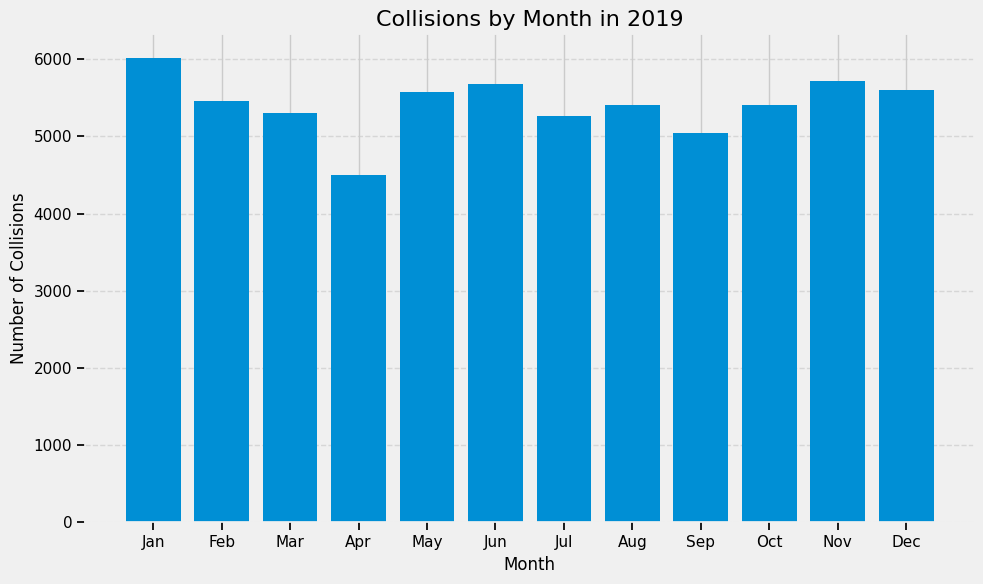

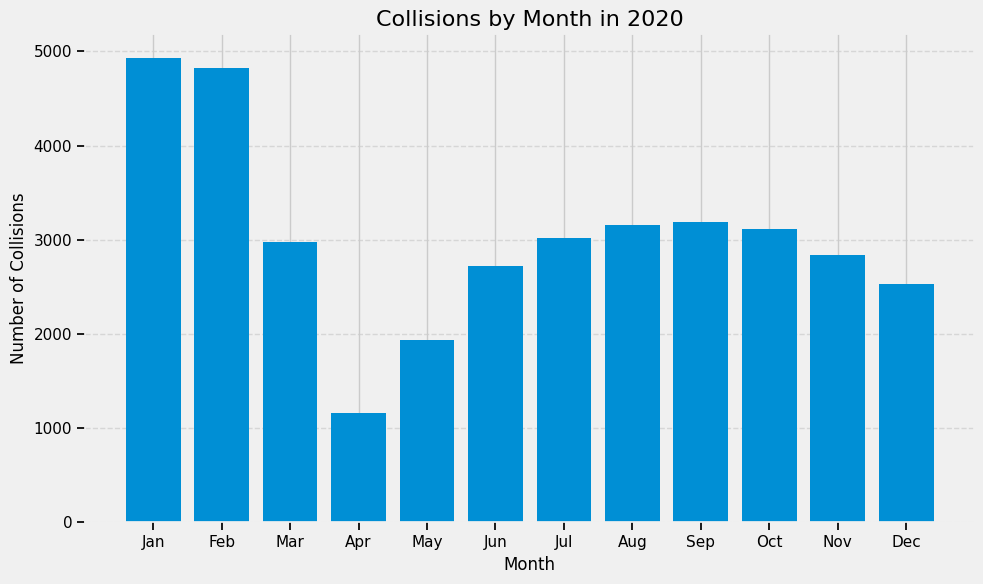

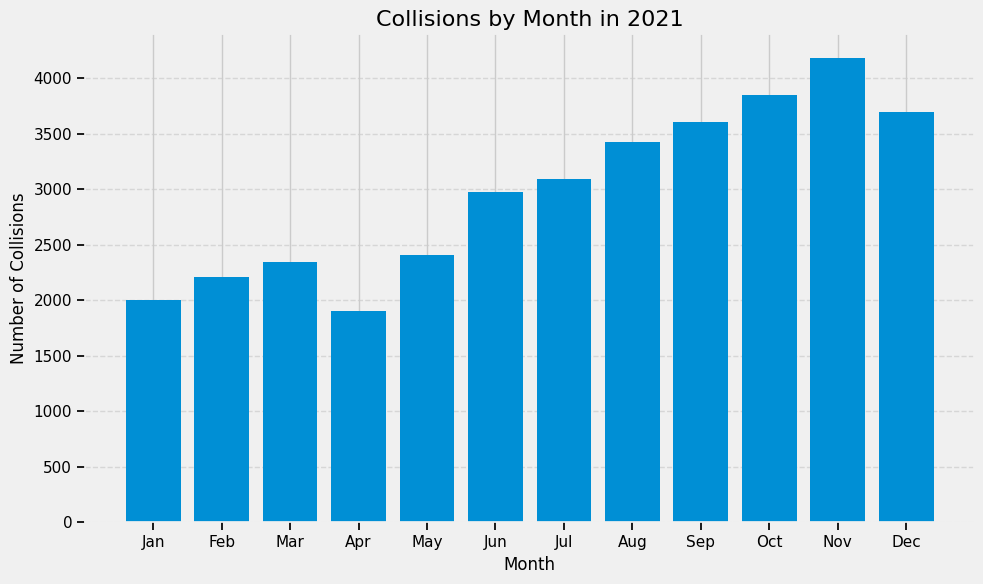

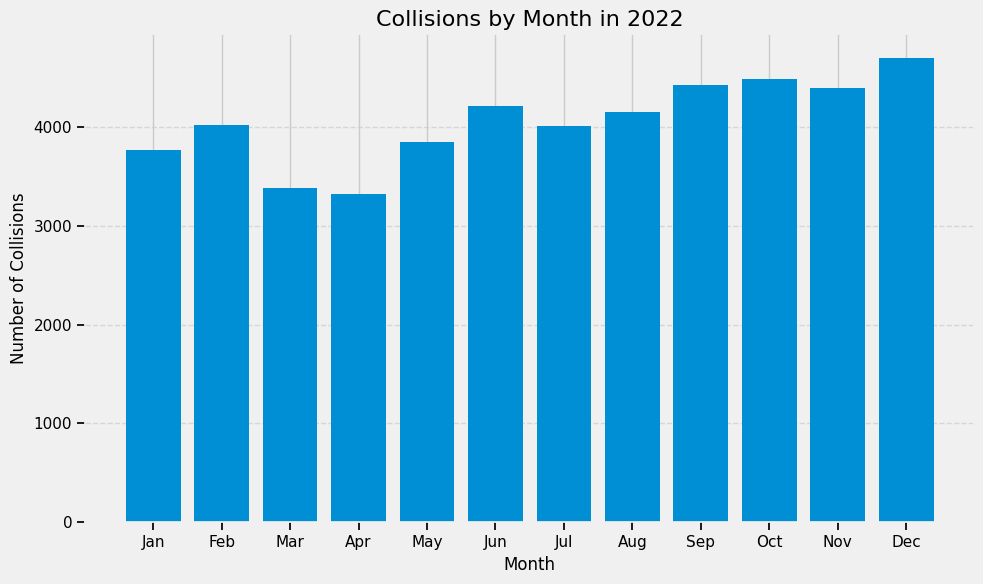

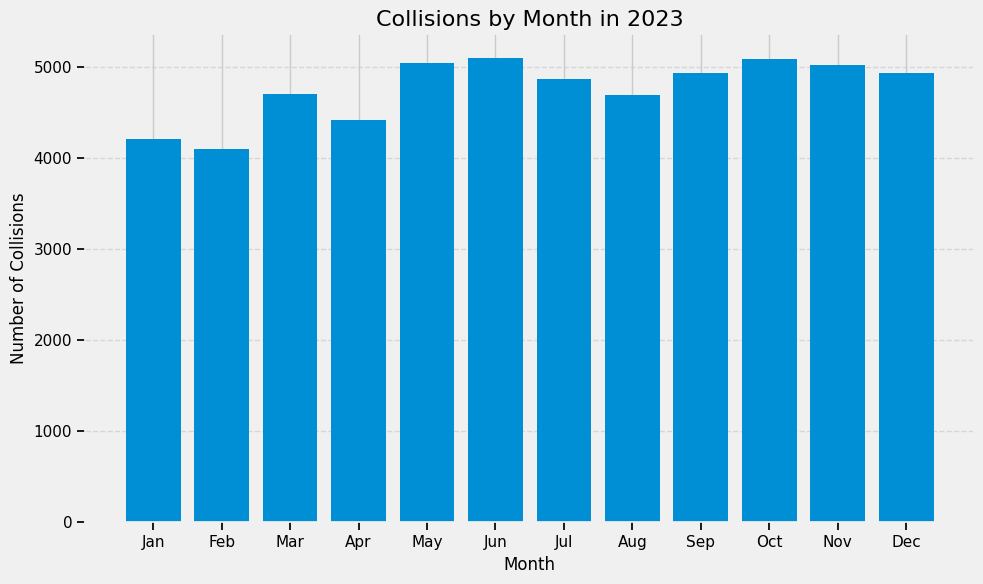

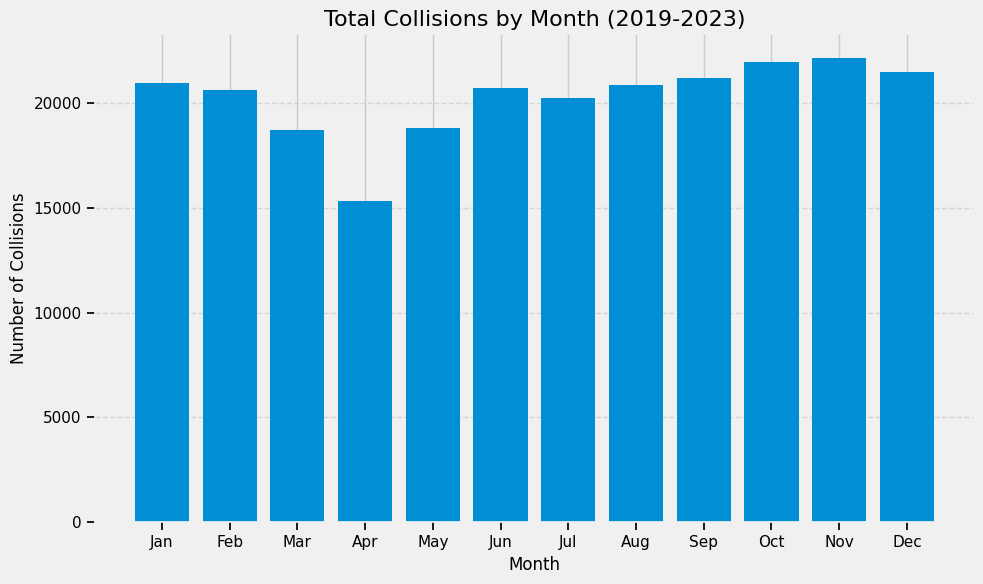

In [39]:
# Group collisions by year and month
monthly_collisions = collision_table.groupby(['Year', 'Month']).size().reset_index(name='Number of Collisions')

# Generate graphs for each year
years = range(2019, 2024)
for year in years:
    yearly_data = monthly_collisions[monthly_collisions['Year'] == year]
    
    plt.figure(figsize=(10, 6))
    plt.bar(yearly_data['Month'], yearly_data['Number of Collisions'])
    plt.title(f'Collisions by Month in {year}', fontsize=16)
    plt.xlabel('Month', fontsize=12)
    plt.ylabel('Number of Collisions', fontsize=12)
    plt.xticks(range(1, 13), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

# Overall graph for 2019 to 2023
overall_monthly_collisions = monthly_collisions.groupby('Month')['Number of Collisions'].sum().reset_index()

plt.figure(figsize=(10, 6))
plt.bar(overall_monthly_collisions['Month'], overall_monthly_collisions['Number of Collisions'])
plt.title('Total Collisions by Month (2019-2023)', fontsize=16)
plt.xlabel('Month', fontsize=12)
plt.ylabel('Number of Collisions', fontsize=12)
plt.xticks(range(1, 13), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

### Collisions Across all Wards Day of the Week

In [40]:
# Ensure the 'DATE' column is in datetime format
collision_table['DATE'] = pd.to_datetime(collision_table['DATE'])

# Extract the day of the week for grouping
collision_table['Day of Week'] = collision_table['DATE'].dt.day_name()

# Group collisions by day of the week (across all years from 2019 to 2023)
overall_daily_collisions = collision_table.groupby('Day of Week').size().reset_index(name='Number of Collisions')

# Calculate the total number of collisions for the percentage calculation
total_collisions = overall_daily_collisions['Number of Collisions'].sum()
overall_daily_collisions['Percentage of Collisions'] = (overall_daily_collisions['Number of Collisions'] / total_collisions) * 100

# Sort the days of the week in chronological order
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
overall_daily_collisions['Day of Week'] = pd.Categorical(overall_daily_collisions['Day of Week'], categories=day_order, ordered=True)
overall_daily_collisions = overall_daily_collisions.sort_values('Day of Week')

# Display the overall table for days of the week
overall_daily_collisions.head(7)

,Day of Week,Number of Collisions,Percentage of Collisions
1,Monday,32100,13.214444
5,Tuesday,36520,15.034004
6,Wednesday,37141,15.289647
4,Thursday,38402,15.808757
0,Friday,40601,16.714008
2,Saturday,32502,13.379934
3,Sunday,25650,10.559206


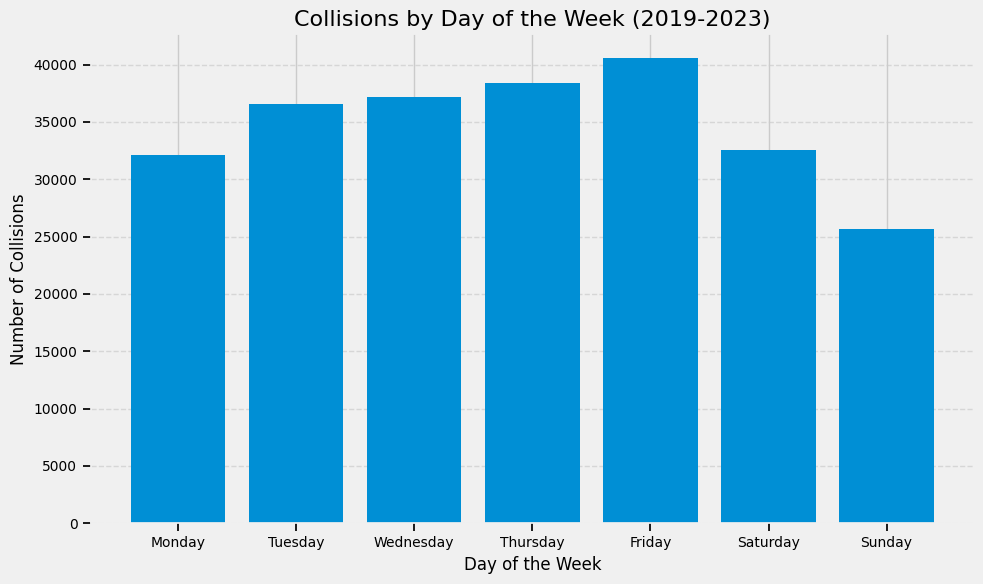

In [41]:
# Plot collisions by day of the week
plt.figure(figsize=(10, 6))
plt.bar(overall_daily_collisions['Day of Week'], overall_daily_collisions['Number of Collisions'])
plt.title('Collisions by Day of the Week (2019-2023)', fontsize=16)
plt.xlabel('Day of the Week', fontsize=12)
plt.ylabel('Number of Collisions', fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [42]:
# Ensure the 'DATE' column is in datetime format
collision_table['DATE'] = pd.to_datetime(collision_table['DATE'])

# Extract the day of the week
collision_table['Day of Week'] = collision_table['DATE'].dt.day_name()

# Group collisions by Ward Number and Day of the Week
ward_daily_collisions = collision_table.groupby(['Ward_Number', 'Day of Week']).size().reset_index(name='Number of Collisions')

# Pivot the table so days of the week are columns and wards are rows
ward_daily_pivot = ward_daily_collisions.pivot(index='Ward_Number', columns='Day of Week', values='Number of Collisions').fillna(0)

# Sort columns (days of the week) in chronological order
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
ward_daily_pivot = ward_daily_pivot[day_order]

# Add a total column for each ward
ward_daily_pivot['Total Collisions'] = ward_daily_pivot.sum(axis=1)

# Display the table for collisions by ward
ward_daily_pivot.head(25)  

Day of Week,Monday,Tuesday,Wednesday,Thursday,Friday,Saturday,Sunday,Total Collisions
Ward_Number,,,,,,,,
01,1633,1632,1671,1782,1949,1479,1179,11325
02,920,1057,1090,1152,1101,808,654,6782
03,1617,1826,1867,1866,2012,1619,1254,12061
04,1101,1365,1375,1487,1442,1326,1051,9147
05,1276,1502,1573,1592,1811,1463,1213,10430
06,1523,1752,1690,1748,1919,1440,1092,11164
07,1208,1300,1412,1410,1607,1150,973,9060
08,1331,1547,1509,1677,1553,1237,993,9847
09,1044,1158,1213,1375,1404,1224,966,8384


### Collisions across all Ward for Time of Day

In [43]:
# Group collisions by time of the day
time_of_day_collisions = collision_table.groupby('TIME_OF_DAY').size().reset_index(name='Number of Collisions')

# Calculate the total number of collisions for the percentage calculation
total_collisions = time_of_day_collisions['Number of Collisions'].sum()
time_of_day_collisions['Percentage of Collisions'] = (time_of_day_collisions['Number of Collisions'] / total_collisions) * 100

# Sort the time of day categories in logical order
time_order = ['Morning (5 AM - 12 PM)', 'Afternoon (12 PM - 5 PM)', 'Evening (5 PM - 9 PM)', 'Night (9 PM - 5 AM)']
time_of_day_collisions['TIME_OF_DAY'] = pd.Categorical(time_of_day_collisions['TIME_OF_DAY'], categories=time_order, ordered=True)
time_of_day_collisions = time_of_day_collisions.sort_values('TIME_OF_DAY')

time_of_day_collisions.head(7)

,TIME_OF_DAY,Number of Collisions,Percentage of Collisions
2,Morning (5 AM - 12 PM),67405,27.748275
0,Afternoon (12 PM - 5 PM),88701,36.515092
1,Evening (5 PM - 9 PM),55517,22.854402
3,Night (9 PM - 5 AM),31293,12.882231


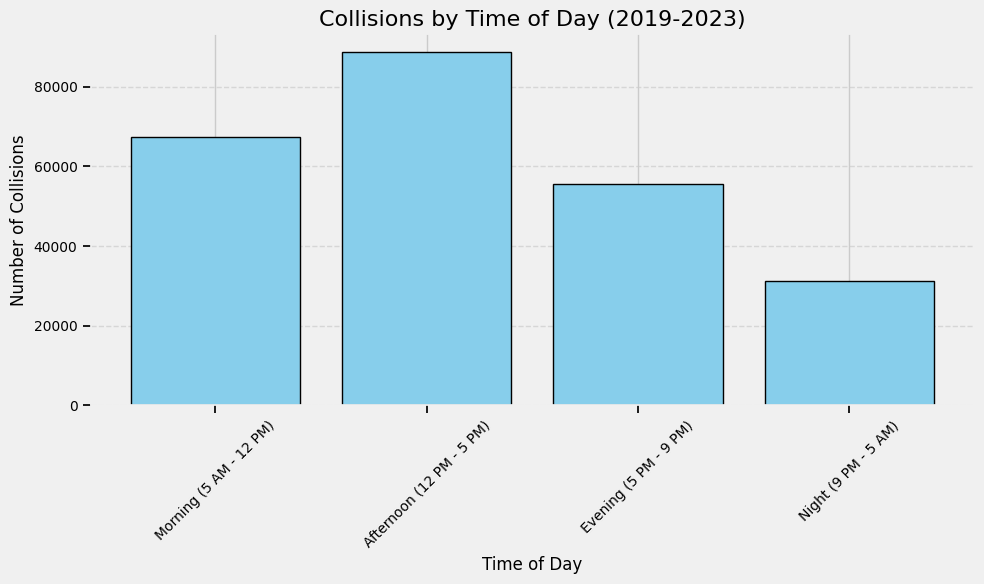

In [44]:
# Plot collisions by time of the day
plt.figure(figsize=(10, 6))
plt.bar(
    time_of_day_collisions['TIME_OF_DAY'], 
    time_of_day_collisions['Number of Collisions'], 
    color='skyblue', 
    edgecolor='black'
)

# Add a title and labels
plt.title('Collisions by Time of Day (2019-2023)', fontsize=16)
plt.xlabel('Time of Day', fontsize=12)
plt.ylabel('Number of Collisions', fontsize=12)

# Customize tick labels
plt.xticks(fontsize=10, rotation=45)
plt.yticks(fontsize=10)

# Add grid lines for better readability
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Adjust layout for better fit
plt.tight_layout()

# Display the plot
plt.show()